# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.08KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

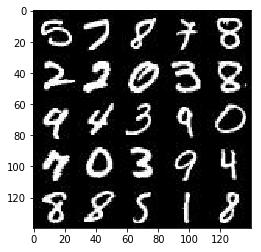

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

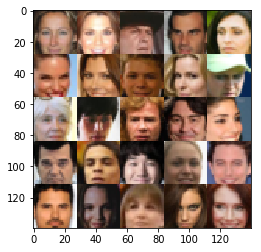

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.01
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.01
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 4.2733... Generator Loss: 0.0350
Epoch 1/2... Batch 20... Discriminator Loss: 1.9235... Generator Loss: 0.3421
Epoch 1/2... Batch 30... Discriminator Loss: 1.8818... Generator Loss: 0.3402
Epoch 1/2... Batch 40... Discriminator Loss: 2.7015... Generator Loss: 0.2609
Epoch 1/2... Batch 50... Discriminator Loss: 1.7777... Generator Loss: 0.8048
Epoch 1/2... Batch 60... Discriminator Loss: 2.0727... Generator Loss: 0.2518
Epoch 1/2... Batch 70... Discriminator Loss: 1.7344... Generator Loss: 0.4066
Epoch 1/2... Batch 80... Discriminator Loss: 1.5868... Generator Loss: 0.4376
Epoch 1/2... Batch 90... Discriminator Loss: 1.6899... Generator Loss: 0.6209
Epoch 1/2... Batch 100... Discriminator Loss: 1.6005... Generator Loss: 0.6869


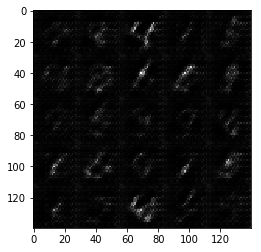

Epoch 1/2... Batch 110... Discriminator Loss: 1.5994... Generator Loss: 0.5576
Epoch 1/2... Batch 120... Discriminator Loss: 1.7885... Generator Loss: 1.1833
Epoch 1/2... Batch 130... Discriminator Loss: 1.5966... Generator Loss: 0.5563
Epoch 1/2... Batch 140... Discriminator Loss: 1.5308... Generator Loss: 0.5479
Epoch 1/2... Batch 150... Discriminator Loss: 1.5239... Generator Loss: 0.7190
Epoch 1/2... Batch 160... Discriminator Loss: 1.7189... Generator Loss: 0.4108
Epoch 1/2... Batch 170... Discriminator Loss: 1.4989... Generator Loss: 0.7992
Epoch 1/2... Batch 180... Discriminator Loss: 1.5422... Generator Loss: 0.6155
Epoch 1/2... Batch 190... Discriminator Loss: 1.6800... Generator Loss: 0.8863
Epoch 1/2... Batch 200... Discriminator Loss: 1.6035... Generator Loss: 0.4468


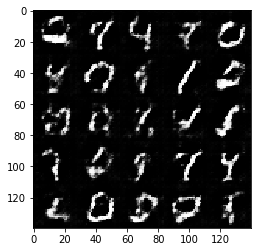

Epoch 1/2... Batch 210... Discriminator Loss: 1.4289... Generator Loss: 0.9374
Epoch 1/2... Batch 220... Discriminator Loss: 1.5602... Generator Loss: 0.5569
Epoch 1/2... Batch 230... Discriminator Loss: 1.5426... Generator Loss: 0.4954
Epoch 1/2... Batch 240... Discriminator Loss: 1.4883... Generator Loss: 0.5161
Epoch 1/2... Batch 250... Discriminator Loss: 1.5128... Generator Loss: 1.0528
Epoch 1/2... Batch 260... Discriminator Loss: 1.6103... Generator Loss: 0.6672
Epoch 1/2... Batch 270... Discriminator Loss: 1.6532... Generator Loss: 0.4541
Epoch 1/2... Batch 280... Discriminator Loss: 1.7147... Generator Loss: 0.3387
Epoch 1/2... Batch 290... Discriminator Loss: 1.5018... Generator Loss: 0.7026
Epoch 1/2... Batch 300... Discriminator Loss: 1.5090... Generator Loss: 0.8792


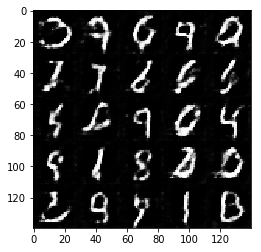

Epoch 1/2... Batch 310... Discriminator Loss: 1.5529... Generator Loss: 0.4744
Epoch 1/2... Batch 320... Discriminator Loss: 1.4533... Generator Loss: 1.0108
Epoch 1/2... Batch 330... Discriminator Loss: 1.4548... Generator Loss: 0.8415
Epoch 1/2... Batch 340... Discriminator Loss: 1.4570... Generator Loss: 0.6464
Epoch 1/2... Batch 350... Discriminator Loss: 1.5940... Generator Loss: 0.4165
Epoch 1/2... Batch 360... Discriminator Loss: 1.4351... Generator Loss: 0.8149
Epoch 1/2... Batch 370... Discriminator Loss: 1.6129... Generator Loss: 0.4307
Epoch 1/2... Batch 380... Discriminator Loss: 1.4988... Generator Loss: 0.8203
Epoch 1/2... Batch 390... Discriminator Loss: 1.4889... Generator Loss: 0.7731
Epoch 1/2... Batch 400... Discriminator Loss: 1.4809... Generator Loss: 0.6068


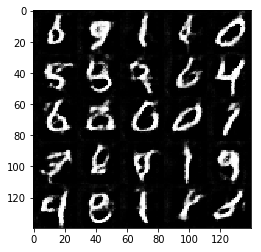

Epoch 1/2... Batch 410... Discriminator Loss: 1.8318... Generator Loss: 0.2983
Epoch 1/2... Batch 420... Discriminator Loss: 1.4686... Generator Loss: 0.6756
Epoch 1/2... Batch 430... Discriminator Loss: 1.5161... Generator Loss: 0.7700
Epoch 1/2... Batch 440... Discriminator Loss: 1.4234... Generator Loss: 0.9298
Epoch 1/2... Batch 450... Discriminator Loss: 1.4929... Generator Loss: 0.5886
Epoch 1/2... Batch 460... Discriminator Loss: 1.5715... Generator Loss: 0.9335
Epoch 1/2... Batch 470... Discriminator Loss: 1.3865... Generator Loss: 0.8792
Epoch 1/2... Batch 480... Discriminator Loss: 1.4563... Generator Loss: 0.8034
Epoch 1/2... Batch 490... Discriminator Loss: 1.6040... Generator Loss: 0.4136
Epoch 1/2... Batch 500... Discriminator Loss: 1.5135... Generator Loss: 0.6150


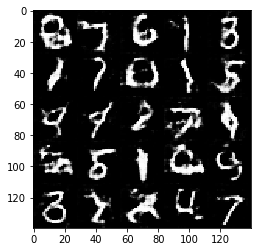

Epoch 1/2... Batch 510... Discriminator Loss: 1.4948... Generator Loss: 0.6719
Epoch 1/2... Batch 520... Discriminator Loss: 1.6288... Generator Loss: 0.4453
Epoch 1/2... Batch 530... Discriminator Loss: 1.4565... Generator Loss: 0.7098
Epoch 1/2... Batch 540... Discriminator Loss: 1.7167... Generator Loss: 0.3438
Epoch 1/2... Batch 550... Discriminator Loss: 1.5009... Generator Loss: 0.7543
Epoch 1/2... Batch 560... Discriminator Loss: 1.4742... Generator Loss: 0.5031
Epoch 1/2... Batch 570... Discriminator Loss: 1.4331... Generator Loss: 0.6436
Epoch 1/2... Batch 580... Discriminator Loss: 1.5682... Generator Loss: 0.9275
Epoch 1/2... Batch 590... Discriminator Loss: 1.5065... Generator Loss: 0.5961
Epoch 1/2... Batch 600... Discriminator Loss: 1.5085... Generator Loss: 0.6717


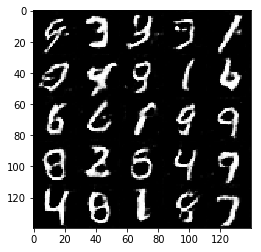

Epoch 1/2... Batch 610... Discriminator Loss: 1.5543... Generator Loss: 0.4877
Epoch 1/2... Batch 620... Discriminator Loss: 2.3171... Generator Loss: 0.1680
Epoch 1/2... Batch 630... Discriminator Loss: 1.4956... Generator Loss: 0.7356
Epoch 1/2... Batch 640... Discriminator Loss: 1.5753... Generator Loss: 0.4478
Epoch 1/2... Batch 650... Discriminator Loss: 1.5141... Generator Loss: 0.5300
Epoch 1/2... Batch 660... Discriminator Loss: 1.5965... Generator Loss: 0.4146
Epoch 1/2... Batch 670... Discriminator Loss: 1.6114... Generator Loss: 1.0159
Epoch 1/2... Batch 680... Discriminator Loss: 1.5177... Generator Loss: 0.5197
Epoch 1/2... Batch 690... Discriminator Loss: 1.4854... Generator Loss: 0.8155
Epoch 1/2... Batch 700... Discriminator Loss: 1.4160... Generator Loss: 0.9120


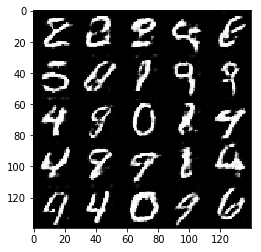

Epoch 1/2... Batch 710... Discriminator Loss: 1.6867... Generator Loss: 0.3588
Epoch 1/2... Batch 720... Discriminator Loss: 1.4925... Generator Loss: 0.6276
Epoch 1/2... Batch 730... Discriminator Loss: 1.5500... Generator Loss: 0.4606
Epoch 1/2... Batch 740... Discriminator Loss: 1.7988... Generator Loss: 1.5851
Epoch 1/2... Batch 750... Discriminator Loss: 1.4367... Generator Loss: 0.6834
Epoch 1/2... Batch 760... Discriminator Loss: 1.4648... Generator Loss: 1.1375
Epoch 1/2... Batch 770... Discriminator Loss: 1.4950... Generator Loss: 0.5894
Epoch 1/2... Batch 780... Discriminator Loss: 1.4726... Generator Loss: 0.7129
Epoch 1/2... Batch 790... Discriminator Loss: 1.5898... Generator Loss: 0.5201
Epoch 1/2... Batch 800... Discriminator Loss: 1.4914... Generator Loss: 0.5970


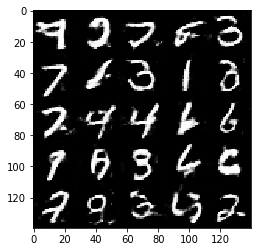

Epoch 1/2... Batch 810... Discriminator Loss: 1.5452... Generator Loss: 0.5454
Epoch 1/2... Batch 820... Discriminator Loss: 1.4832... Generator Loss: 0.8681
Epoch 1/2... Batch 830... Discriminator Loss: 1.6255... Generator Loss: 0.4772
Epoch 1/2... Batch 840... Discriminator Loss: 1.4061... Generator Loss: 0.6135
Epoch 1/2... Batch 850... Discriminator Loss: 1.4863... Generator Loss: 0.5867
Epoch 1/2... Batch 860... Discriminator Loss: 1.5985... Generator Loss: 0.5199
Epoch 1/2... Batch 870... Discriminator Loss: 1.4696... Generator Loss: 0.8775
Epoch 1/2... Batch 880... Discriminator Loss: 1.3861... Generator Loss: 0.7102
Epoch 1/2... Batch 890... Discriminator Loss: 1.5121... Generator Loss: 0.5954
Epoch 1/2... Batch 900... Discriminator Loss: 1.4349... Generator Loss: 0.5869


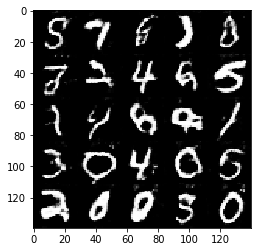

Epoch 1/2... Batch 910... Discriminator Loss: 1.4532... Generator Loss: 0.6446
Epoch 1/2... Batch 920... Discriminator Loss: 1.5328... Generator Loss: 0.4692
Epoch 1/2... Batch 930... Discriminator Loss: 1.4611... Generator Loss: 1.1096
Epoch 2/2... Batch 10... Discriminator Loss: 1.4076... Generator Loss: 0.7302
Epoch 2/2... Batch 20... Discriminator Loss: 1.4693... Generator Loss: 0.6965
Epoch 2/2... Batch 30... Discriminator Loss: 1.4973... Generator Loss: 0.5668
Epoch 2/2... Batch 40... Discriminator Loss: 1.6446... Generator Loss: 0.3766
Epoch 2/2... Batch 50... Discriminator Loss: 1.4096... Generator Loss: 0.6620
Epoch 2/2... Batch 60... Discriminator Loss: 1.4624... Generator Loss: 0.5746
Epoch 2/2... Batch 70... Discriminator Loss: 1.6925... Generator Loss: 0.3557
Epoch 2/2... Batch 80... Discriminator Loss: 1.4967... Generator Loss: 0.5390
Epoch 2/2... Batch 90... Discriminator Loss: 1.4741... Generator Loss: 1.2981
Epoch 2/2... Batch 100... Discriminator Loss: 1.4579... Gener

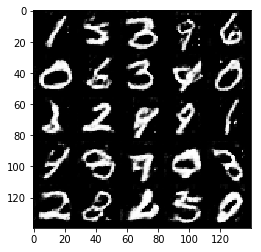

Epoch 2/2... Batch 110... Discriminator Loss: 1.4966... Generator Loss: 0.5798
Epoch 2/2... Batch 120... Discriminator Loss: 1.3596... Generator Loss: 0.6702
Epoch 2/2... Batch 130... Discriminator Loss: 1.5945... Generator Loss: 0.4161
Epoch 2/2... Batch 140... Discriminator Loss: 1.6600... Generator Loss: 1.5047
Epoch 2/2... Batch 150... Discriminator Loss: 1.3532... Generator Loss: 0.6203
Epoch 2/2... Batch 160... Discriminator Loss: 1.5018... Generator Loss: 0.9768
Epoch 2/2... Batch 170... Discriminator Loss: 1.4559... Generator Loss: 0.5806
Epoch 2/2... Batch 180... Discriminator Loss: 1.8089... Generator Loss: 0.2968
Epoch 2/2... Batch 190... Discriminator Loss: 1.4456... Generator Loss: 0.6073
Epoch 2/2... Batch 200... Discriminator Loss: 1.5811... Generator Loss: 0.4242


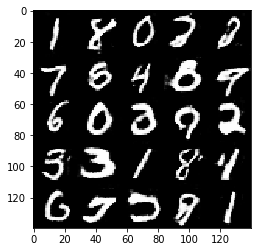

Epoch 2/2... Batch 210... Discriminator Loss: 1.7480... Generator Loss: 0.3165
Epoch 2/2... Batch 220... Discriminator Loss: 1.6303... Generator Loss: 0.4110
Epoch 2/2... Batch 230... Discriminator Loss: 1.6535... Generator Loss: 0.3898
Epoch 2/2... Batch 240... Discriminator Loss: 1.3691... Generator Loss: 0.8266
Epoch 2/2... Batch 250... Discriminator Loss: 1.4697... Generator Loss: 1.1304
Epoch 2/2... Batch 260... Discriminator Loss: 1.3953... Generator Loss: 0.6076
Epoch 2/2... Batch 270... Discriminator Loss: 1.5469... Generator Loss: 0.5216
Epoch 2/2... Batch 280... Discriminator Loss: 1.5349... Generator Loss: 0.4842
Epoch 2/2... Batch 290... Discriminator Loss: 1.6597... Generator Loss: 0.4263
Epoch 2/2... Batch 300... Discriminator Loss: 1.3391... Generator Loss: 0.7234


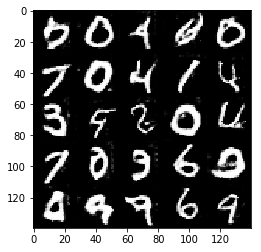

Epoch 2/2... Batch 310... Discriminator Loss: 1.3763... Generator Loss: 0.5657
Epoch 2/2... Batch 320... Discriminator Loss: 1.4146... Generator Loss: 0.6593
Epoch 2/2... Batch 330... Discriminator Loss: 1.8479... Generator Loss: 0.2850
Epoch 2/2... Batch 340... Discriminator Loss: 1.7073... Generator Loss: 0.3415
Epoch 2/2... Batch 350... Discriminator Loss: 1.5765... Generator Loss: 0.3969
Epoch 2/2... Batch 360... Discriminator Loss: 1.4260... Generator Loss: 0.9136
Epoch 2/2... Batch 370... Discriminator Loss: 1.5549... Generator Loss: 0.4279
Epoch 2/2... Batch 380... Discriminator Loss: 1.6876... Generator Loss: 0.3533
Epoch 2/2... Batch 390... Discriminator Loss: 1.4168... Generator Loss: 0.6251
Epoch 2/2... Batch 400... Discriminator Loss: 1.5490... Generator Loss: 0.4582


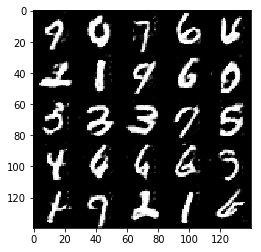

Epoch 2/2... Batch 410... Discriminator Loss: 1.4826... Generator Loss: 0.5695
Epoch 2/2... Batch 420... Discriminator Loss: 1.4449... Generator Loss: 0.6961
Epoch 2/2... Batch 430... Discriminator Loss: 1.4785... Generator Loss: 0.9578
Epoch 2/2... Batch 440... Discriminator Loss: 1.7713... Generator Loss: 0.3212
Epoch 2/2... Batch 450... Discriminator Loss: 1.5506... Generator Loss: 0.5212
Epoch 2/2... Batch 460... Discriminator Loss: 1.5981... Generator Loss: 0.3986
Epoch 2/2... Batch 470... Discriminator Loss: 1.2923... Generator Loss: 1.1689
Epoch 2/2... Batch 480... Discriminator Loss: 1.5478... Generator Loss: 0.4767
Epoch 2/2... Batch 490... Discriminator Loss: 1.4908... Generator Loss: 0.6129
Epoch 2/2... Batch 500... Discriminator Loss: 1.4574... Generator Loss: 0.6161


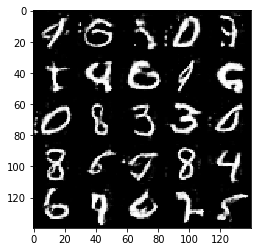

Epoch 2/2... Batch 510... Discriminator Loss: 1.3519... Generator Loss: 0.6789
Epoch 2/2... Batch 520... Discriminator Loss: 1.4838... Generator Loss: 0.5910
Epoch 2/2... Batch 530... Discriminator Loss: 1.4327... Generator Loss: 0.8452
Epoch 2/2... Batch 540... Discriminator Loss: 1.6530... Generator Loss: 0.3678
Epoch 2/2... Batch 550... Discriminator Loss: 1.5951... Generator Loss: 0.5266
Epoch 2/2... Batch 560... Discriminator Loss: 1.4402... Generator Loss: 0.9895
Epoch 2/2... Batch 570... Discriminator Loss: 1.2871... Generator Loss: 0.7141
Epoch 2/2... Batch 580... Discriminator Loss: 1.4931... Generator Loss: 0.5061
Epoch 2/2... Batch 590... Discriminator Loss: 1.5094... Generator Loss: 0.4566
Epoch 2/2... Batch 600... Discriminator Loss: 2.3798... Generator Loss: 2.1637


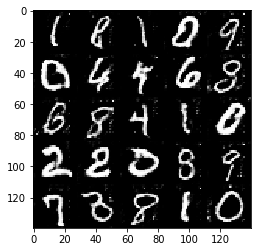

Epoch 2/2... Batch 610... Discriminator Loss: 1.4758... Generator Loss: 0.7519
Epoch 2/2... Batch 620... Discriminator Loss: 1.4751... Generator Loss: 0.5811
Epoch 2/2... Batch 630... Discriminator Loss: 1.6686... Generator Loss: 0.3631
Epoch 2/2... Batch 640... Discriminator Loss: 1.9245... Generator Loss: 0.2681
Epoch 2/2... Batch 650... Discriminator Loss: 1.3707... Generator Loss: 0.7298
Epoch 2/2... Batch 660... Discriminator Loss: 1.5590... Generator Loss: 0.4827
Epoch 2/2... Batch 670... Discriminator Loss: 1.2613... Generator Loss: 1.0663
Epoch 2/2... Batch 680... Discriminator Loss: 1.2325... Generator Loss: 0.9126
Epoch 2/2... Batch 690... Discriminator Loss: 1.4704... Generator Loss: 0.7035
Epoch 2/2... Batch 700... Discriminator Loss: 1.5610... Generator Loss: 0.4762


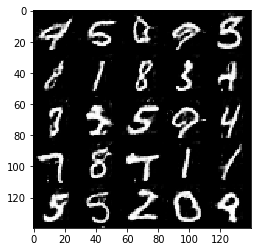

Epoch 2/2... Batch 710... Discriminator Loss: 1.6298... Generator Loss: 0.3876
Epoch 2/2... Batch 720... Discriminator Loss: 1.4317... Generator Loss: 0.7270
Epoch 2/2... Batch 730... Discriminator Loss: 1.6713... Generator Loss: 0.3830
Epoch 2/2... Batch 740... Discriminator Loss: 1.4996... Generator Loss: 1.6402
Epoch 2/2... Batch 750... Discriminator Loss: 1.7828... Generator Loss: 0.3059
Epoch 2/2... Batch 760... Discriminator Loss: 1.2766... Generator Loss: 0.9077
Epoch 2/2... Batch 770... Discriminator Loss: 1.5563... Generator Loss: 0.4560
Epoch 2/2... Batch 780... Discriminator Loss: 1.9565... Generator Loss: 0.2793
Epoch 2/2... Batch 790... Discriminator Loss: 1.4754... Generator Loss: 0.5660
Epoch 2/2... Batch 800... Discriminator Loss: 1.2695... Generator Loss: 0.7985


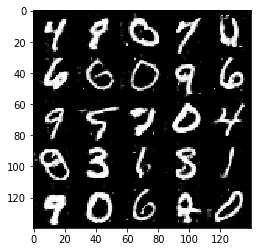

Epoch 2/2... Batch 810... Discriminator Loss: 1.9524... Generator Loss: 0.2766
Epoch 2/2... Batch 820... Discriminator Loss: 1.4496... Generator Loss: 0.5390
Epoch 2/2... Batch 830... Discriminator Loss: 1.3609... Generator Loss: 0.7233
Epoch 2/2... Batch 840... Discriminator Loss: 1.5383... Generator Loss: 0.4851
Epoch 2/2... Batch 850... Discriminator Loss: 1.4042... Generator Loss: 0.5678
Epoch 2/2... Batch 860... Discriminator Loss: 1.4477... Generator Loss: 0.6480
Epoch 2/2... Batch 870... Discriminator Loss: 1.8088... Generator Loss: 1.6959
Epoch 2/2... Batch 880... Discriminator Loss: 1.5966... Generator Loss: 0.4414
Epoch 2/2... Batch 890... Discriminator Loss: 1.3761... Generator Loss: 0.5889
Epoch 2/2... Batch 900... Discriminator Loss: 1.7627... Generator Loss: 0.3261


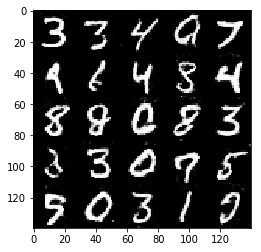

Epoch 2/2... Batch 910... Discriminator Loss: 1.5938... Generator Loss: 0.4022
Epoch 2/2... Batch 920... Discriminator Loss: 1.8727... Generator Loss: 0.2907
Epoch 2/2... Batch 930... Discriminator Loss: 1.6460... Generator Loss: 0.4204


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.3653... Generator Loss: 2.5593
Epoch 1/1... Batch 20... Discriminator Loss: 2.6975... Generator Loss: 0.2486
Epoch 1/1... Batch 30... Discriminator Loss: 2.5670... Generator Loss: 0.3231
Epoch 1/1... Batch 40... Discriminator Loss: 1.7389... Generator Loss: 0.8073
Epoch 1/1... Batch 50... Discriminator Loss: 1.9002... Generator Loss: 0.6419
Epoch 1/1... Batch 60... Discriminator Loss: 1.9470... Generator Loss: 0.9163
Epoch 1/1... Batch 70... Discriminator Loss: 1.9899... Generator Loss: 0.5442
Epoch 1/1... Batch 80... Discriminator Loss: 1.8726... Generator Loss: 0.4469
Epoch 1/1... Batch 90... Discriminator Loss: 1.7925... Generator Loss: 0.5670
Epoch 1/1... Batch 100... Discriminator Loss: 1.7111... Generator Loss: 0.6119


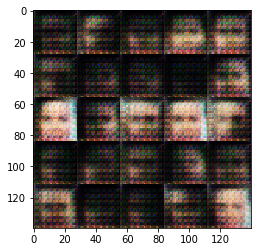

Epoch 1/1... Batch 110... Discriminator Loss: 1.6013... Generator Loss: 0.5965
Epoch 1/1... Batch 120... Discriminator Loss: 1.6134... Generator Loss: 0.5937
Epoch 1/1... Batch 130... Discriminator Loss: 1.6031... Generator Loss: 0.7041
Epoch 1/1... Batch 140... Discriminator Loss: 1.3841... Generator Loss: 0.7928
Epoch 1/1... Batch 150... Discriminator Loss: 1.6654... Generator Loss: 0.7116
Epoch 1/1... Batch 160... Discriminator Loss: 1.7676... Generator Loss: 0.6800
Epoch 1/1... Batch 170... Discriminator Loss: 1.5638... Generator Loss: 0.6503
Epoch 1/1... Batch 180... Discriminator Loss: 1.6211... Generator Loss: 0.4850
Epoch 1/1... Batch 190... Discriminator Loss: 1.7286... Generator Loss: 0.5612
Epoch 1/1... Batch 200... Discriminator Loss: 1.8830... Generator Loss: 0.3443


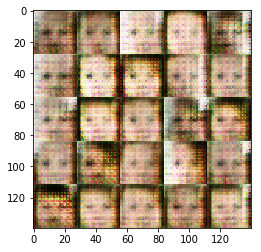

Epoch 1/1... Batch 210... Discriminator Loss: 1.6418... Generator Loss: 0.8962
Epoch 1/1... Batch 220... Discriminator Loss: 1.5362... Generator Loss: 0.9848
Epoch 1/1... Batch 230... Discriminator Loss: 1.5701... Generator Loss: 1.6485
Epoch 1/1... Batch 240... Discriminator Loss: 1.5230... Generator Loss: 0.7685
Epoch 1/1... Batch 250... Discriminator Loss: 1.5240... Generator Loss: 0.5751
Epoch 1/1... Batch 260... Discriminator Loss: 1.6418... Generator Loss: 0.5900
Epoch 1/1... Batch 270... Discriminator Loss: 1.6099... Generator Loss: 1.0286
Epoch 1/1... Batch 280... Discriminator Loss: 1.4815... Generator Loss: 0.8061
Epoch 1/1... Batch 290... Discriminator Loss: 1.6023... Generator Loss: 1.5176
Epoch 1/1... Batch 300... Discriminator Loss: 1.9020... Generator Loss: 0.2585


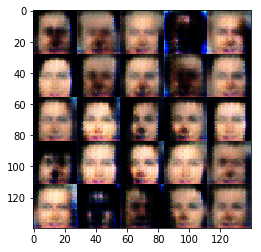

Epoch 1/1... Batch 310... Discriminator Loss: 1.3078... Generator Loss: 1.0686
Epoch 1/1... Batch 320... Discriminator Loss: 1.3638... Generator Loss: 0.8776
Epoch 1/1... Batch 330... Discriminator Loss: 1.4467... Generator Loss: 0.9058
Epoch 1/1... Batch 340... Discriminator Loss: 1.3513... Generator Loss: 1.2861
Epoch 1/1... Batch 350... Discriminator Loss: 1.6515... Generator Loss: 0.5700
Epoch 1/1... Batch 360... Discriminator Loss: 1.5039... Generator Loss: 0.7211
Epoch 1/1... Batch 370... Discriminator Loss: 1.4331... Generator Loss: 0.7000
Epoch 1/1... Batch 380... Discriminator Loss: 1.8095... Generator Loss: 0.2882
Epoch 1/1... Batch 390... Discriminator Loss: 1.5609... Generator Loss: 0.6998
Epoch 1/1... Batch 400... Discriminator Loss: 1.4962... Generator Loss: 0.6930


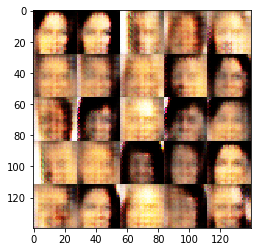

Epoch 1/1... Batch 410... Discriminator Loss: 1.4617... Generator Loss: 0.7656
Epoch 1/1... Batch 420... Discriminator Loss: 1.5426... Generator Loss: 0.5023
Epoch 1/1... Batch 430... Discriminator Loss: 1.5245... Generator Loss: 0.6604
Epoch 1/1... Batch 440... Discriminator Loss: 1.4012... Generator Loss: 0.6530
Epoch 1/1... Batch 450... Discriminator Loss: 1.9193... Generator Loss: 0.2546
Epoch 1/1... Batch 460... Discriminator Loss: 1.5100... Generator Loss: 0.6174
Epoch 1/1... Batch 470... Discriminator Loss: 1.4235... Generator Loss: 0.7362
Epoch 1/1... Batch 480... Discriminator Loss: 1.5709... Generator Loss: 1.4265
Epoch 1/1... Batch 490... Discriminator Loss: 1.3683... Generator Loss: 0.8999
Epoch 1/1... Batch 500... Discriminator Loss: 1.4673... Generator Loss: 0.4707


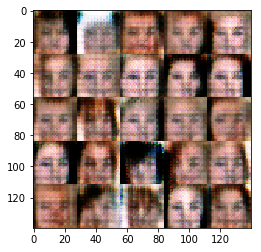

Epoch 1/1... Batch 510... Discriminator Loss: 1.5912... Generator Loss: 0.5172
Epoch 1/1... Batch 520... Discriminator Loss: 1.4783... Generator Loss: 0.6060
Epoch 1/1... Batch 530... Discriminator Loss: 1.3226... Generator Loss: 0.7234
Epoch 1/1... Batch 540... Discriminator Loss: 1.8050... Generator Loss: 0.4533
Epoch 1/1... Batch 550... Discriminator Loss: 1.3778... Generator Loss: 0.7422
Epoch 1/1... Batch 560... Discriminator Loss: 1.6095... Generator Loss: 0.4886
Epoch 1/1... Batch 570... Discriminator Loss: 1.3409... Generator Loss: 0.7950
Epoch 1/1... Batch 580... Discriminator Loss: 1.9165... Generator Loss: 0.2933
Epoch 1/1... Batch 590... Discriminator Loss: 1.6195... Generator Loss: 0.5938
Epoch 1/1... Batch 600... Discriminator Loss: 1.4334... Generator Loss: 0.8550


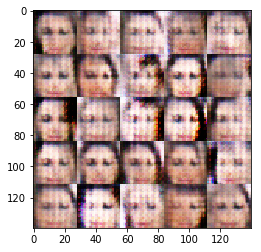

Epoch 1/1... Batch 610... Discriminator Loss: 1.3725... Generator Loss: 0.7466
Epoch 1/1... Batch 620... Discriminator Loss: 1.6783... Generator Loss: 0.3783
Epoch 1/1... Batch 630... Discriminator Loss: 1.4716... Generator Loss: 0.6728
Epoch 1/1... Batch 640... Discriminator Loss: 1.5710... Generator Loss: 0.4280
Epoch 1/1... Batch 650... Discriminator Loss: 1.4609... Generator Loss: 0.8730
Epoch 1/1... Batch 660... Discriminator Loss: 1.5120... Generator Loss: 0.6543
Epoch 1/1... Batch 670... Discriminator Loss: 1.4525... Generator Loss: 0.8188
Epoch 1/1... Batch 680... Discriminator Loss: 1.5016... Generator Loss: 0.7664
Epoch 1/1... Batch 690... Discriminator Loss: 1.3899... Generator Loss: 0.7787
Epoch 1/1... Batch 700... Discriminator Loss: 1.6040... Generator Loss: 0.4704


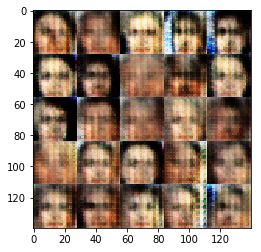

Epoch 1/1... Batch 710... Discriminator Loss: 1.1473... Generator Loss: 0.7230
Epoch 1/1... Batch 720... Discriminator Loss: 1.3913... Generator Loss: 0.8236
Epoch 1/1... Batch 730... Discriminator Loss: 1.4610... Generator Loss: 0.7041
Epoch 1/1... Batch 740... Discriminator Loss: 1.3618... Generator Loss: 0.8086
Epoch 1/1... Batch 750... Discriminator Loss: 1.3876... Generator Loss: 0.7796
Epoch 1/1... Batch 760... Discriminator Loss: 1.4263... Generator Loss: 0.8696
Epoch 1/1... Batch 770... Discriminator Loss: 1.3989... Generator Loss: 0.5886
Epoch 1/1... Batch 780... Discriminator Loss: 1.4284... Generator Loss: 0.9769
Epoch 1/1... Batch 790... Discriminator Loss: 1.6380... Generator Loss: 0.4634
Epoch 1/1... Batch 800... Discriminator Loss: 1.4037... Generator Loss: 0.8042


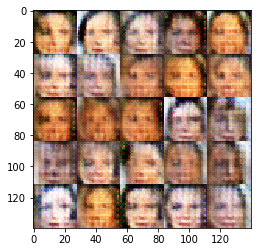

Epoch 1/1... Batch 810... Discriminator Loss: 1.3935... Generator Loss: 0.8383
Epoch 1/1... Batch 820... Discriminator Loss: 1.3593... Generator Loss: 0.8798
Epoch 1/1... Batch 830... Discriminator Loss: 1.3541... Generator Loss: 0.7135
Epoch 1/1... Batch 840... Discriminator Loss: 1.4628... Generator Loss: 0.5730
Epoch 1/1... Batch 850... Discriminator Loss: 1.3818... Generator Loss: 0.8290
Epoch 1/1... Batch 860... Discriminator Loss: 1.3616... Generator Loss: 0.7806
Epoch 1/1... Batch 870... Discriminator Loss: 1.3671... Generator Loss: 0.7936
Epoch 1/1... Batch 880... Discriminator Loss: 1.2484... Generator Loss: 1.1578
Epoch 1/1... Batch 890... Discriminator Loss: 1.3401... Generator Loss: 0.7817
Epoch 1/1... Batch 900... Discriminator Loss: 1.2780... Generator Loss: 0.6522


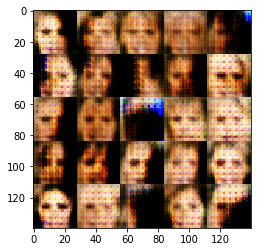

Epoch 1/1... Batch 910... Discriminator Loss: 1.3105... Generator Loss: 0.7394
Epoch 1/1... Batch 920... Discriminator Loss: 2.0074... Generator Loss: 0.2862
Epoch 1/1... Batch 930... Discriminator Loss: 1.3044... Generator Loss: 0.8408
Epoch 1/1... Batch 940... Discriminator Loss: 1.5604... Generator Loss: 0.5581
Epoch 1/1... Batch 950... Discriminator Loss: 1.1360... Generator Loss: 1.0718
Epoch 1/1... Batch 960... Discriminator Loss: 1.4081... Generator Loss: 0.9293
Epoch 1/1... Batch 970... Discriminator Loss: 1.4592... Generator Loss: 0.8443
Epoch 1/1... Batch 980... Discriminator Loss: 1.3866... Generator Loss: 0.7626
Epoch 1/1... Batch 990... Discriminator Loss: 1.3304... Generator Loss: 0.9344
Epoch 1/1... Batch 1000... Discriminator Loss: 2.0223... Generator Loss: 0.3196


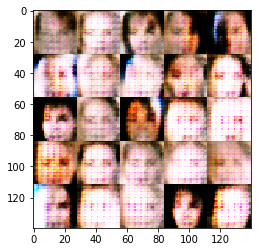

Epoch 1/1... Batch 1010... Discriminator Loss: 1.2537... Generator Loss: 0.7886
Epoch 1/1... Batch 1020... Discriminator Loss: 1.5667... Generator Loss: 0.7113
Epoch 1/1... Batch 1030... Discriminator Loss: 1.3661... Generator Loss: 0.7816
Epoch 1/1... Batch 1040... Discriminator Loss: 1.3359... Generator Loss: 0.8321
Epoch 1/1... Batch 1050... Discriminator Loss: 1.1332... Generator Loss: 0.7031
Epoch 1/1... Batch 1060... Discriminator Loss: 1.2801... Generator Loss: 0.8017
Epoch 1/1... Batch 1070... Discriminator Loss: 1.6133... Generator Loss: 0.4601
Epoch 1/1... Batch 1080... Discriminator Loss: 1.4228... Generator Loss: 0.8416
Epoch 1/1... Batch 1090... Discriminator Loss: 1.3063... Generator Loss: 0.8469
Epoch 1/1... Batch 1100... Discriminator Loss: 1.2994... Generator Loss: 0.6846


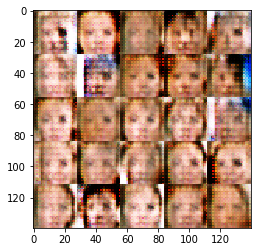

Epoch 1/1... Batch 1110... Discriminator Loss: 1.8569... Generator Loss: 0.3443
Epoch 1/1... Batch 1120... Discriminator Loss: 1.4792... Generator Loss: 1.0465
Epoch 1/1... Batch 1130... Discriminator Loss: 1.6103... Generator Loss: 1.3517
Epoch 1/1... Batch 1140... Discriminator Loss: 2.0205... Generator Loss: 1.2291
Epoch 1/1... Batch 1150... Discriminator Loss: 1.1828... Generator Loss: 0.7891
Epoch 1/1... Batch 1160... Discriminator Loss: 1.2746... Generator Loss: 0.8781
Epoch 1/1... Batch 1170... Discriminator Loss: 1.4412... Generator Loss: 0.4893
Epoch 1/1... Batch 1180... Discriminator Loss: 1.4577... Generator Loss: 0.9521
Epoch 1/1... Batch 1190... Discriminator Loss: 1.9363... Generator Loss: 0.4353
Epoch 1/1... Batch 1200... Discriminator Loss: 1.5039... Generator Loss: 0.7163


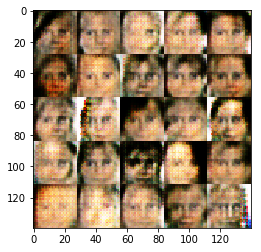

Epoch 1/1... Batch 1210... Discriminator Loss: 1.2270... Generator Loss: 0.5963
Epoch 1/1... Batch 1220... Discriminator Loss: 0.9968... Generator Loss: 1.7170
Epoch 1/1... Batch 1230... Discriminator Loss: 0.9098... Generator Loss: 1.1080
Epoch 1/1... Batch 1240... Discriminator Loss: 2.4563... Generator Loss: 0.2041
Epoch 1/1... Batch 1250... Discriminator Loss: 0.8134... Generator Loss: 1.4025
Epoch 1/1... Batch 1260... Discriminator Loss: 1.0522... Generator Loss: 0.8229
Epoch 1/1... Batch 1270... Discriminator Loss: 0.8951... Generator Loss: 0.9908
Epoch 1/1... Batch 1280... Discriminator Loss: 1.2677... Generator Loss: 0.7814
Epoch 1/1... Batch 1290... Discriminator Loss: 1.4603... Generator Loss: 0.9037
Epoch 1/1... Batch 1300... Discriminator Loss: 1.1181... Generator Loss: 1.0550


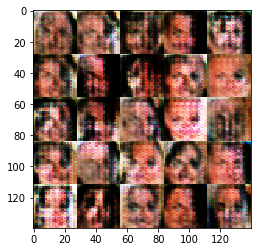

Epoch 1/1... Batch 1310... Discriminator Loss: 1.3134... Generator Loss: 0.9544
Epoch 1/1... Batch 1320... Discriminator Loss: 1.4577... Generator Loss: 1.6172
Epoch 1/1... Batch 1330... Discriminator Loss: 1.8178... Generator Loss: 0.6289
Epoch 1/1... Batch 1340... Discriminator Loss: 1.2350... Generator Loss: 0.9099
Epoch 1/1... Batch 1350... Discriminator Loss: 1.3030... Generator Loss: 0.6611
Epoch 1/1... Batch 1360... Discriminator Loss: 1.3597... Generator Loss: 1.0063
Epoch 1/1... Batch 1370... Discriminator Loss: 1.5087... Generator Loss: 0.5737
Epoch 1/1... Batch 1380... Discriminator Loss: 1.3596... Generator Loss: 0.8523
Epoch 1/1... Batch 1390... Discriminator Loss: 1.6196... Generator Loss: 0.4250
Epoch 1/1... Batch 1400... Discriminator Loss: 1.3688... Generator Loss: 1.0569


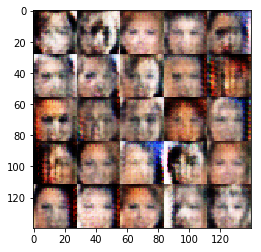

Epoch 1/1... Batch 1410... Discriminator Loss: 1.5573... Generator Loss: 0.9559
Epoch 1/1... Batch 1420... Discriminator Loss: 1.1716... Generator Loss: 0.7089
Epoch 1/1... Batch 1430... Discriminator Loss: 1.2721... Generator Loss: 0.8242
Epoch 1/1... Batch 1440... Discriminator Loss: 1.1840... Generator Loss: 0.7962
Epoch 1/1... Batch 1450... Discriminator Loss: 1.3831... Generator Loss: 1.0353
Epoch 1/1... Batch 1460... Discriminator Loss: 1.4919... Generator Loss: 0.6799
Epoch 1/1... Batch 1470... Discriminator Loss: 1.3291... Generator Loss: 0.8222
Epoch 1/1... Batch 1480... Discriminator Loss: 1.3614... Generator Loss: 0.9943
Epoch 1/1... Batch 1490... Discriminator Loss: 1.3274... Generator Loss: 0.6949
Epoch 1/1... Batch 1500... Discriminator Loss: 1.3034... Generator Loss: 0.7071


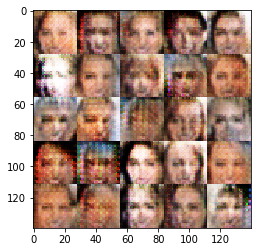

Epoch 1/1... Batch 1510... Discriminator Loss: 1.2461... Generator Loss: 0.8084
Epoch 1/1... Batch 1520... Discriminator Loss: 1.5852... Generator Loss: 0.5880
Epoch 1/1... Batch 1530... Discriminator Loss: 1.3902... Generator Loss: 0.7099
Epoch 1/1... Batch 1540... Discriminator Loss: 1.3887... Generator Loss: 0.9545
Epoch 1/1... Batch 1550... Discriminator Loss: 1.4368... Generator Loss: 0.5651
Epoch 1/1... Batch 1560... Discriminator Loss: 1.2338... Generator Loss: 0.8427
Epoch 1/1... Batch 1570... Discriminator Loss: 1.3032... Generator Loss: 0.8138
Epoch 1/1... Batch 1580... Discriminator Loss: 1.2377... Generator Loss: 0.7649
Epoch 1/1... Batch 1590... Discriminator Loss: 1.2187... Generator Loss: 0.8763
Epoch 1/1... Batch 1600... Discriminator Loss: 1.3545... Generator Loss: 0.6851


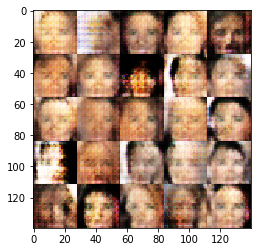

Epoch 1/1... Batch 1610... Discriminator Loss: 1.3203... Generator Loss: 1.0234
Epoch 1/1... Batch 1620... Discriminator Loss: 1.2138... Generator Loss: 0.8557
Epoch 1/1... Batch 1630... Discriminator Loss: 1.3551... Generator Loss: 0.8900
Epoch 1/1... Batch 1640... Discriminator Loss: 1.4193... Generator Loss: 0.9204
Epoch 1/1... Batch 1650... Discriminator Loss: 1.3198... Generator Loss: 1.0944
Epoch 1/1... Batch 1660... Discriminator Loss: 1.6120... Generator Loss: 0.4986
Epoch 1/1... Batch 1670... Discriminator Loss: 0.9086... Generator Loss: 1.1398
Epoch 1/1... Batch 1680... Discriminator Loss: 0.9569... Generator Loss: 1.1226
Epoch 1/1... Batch 1690... Discriminator Loss: 1.4586... Generator Loss: 0.9983
Epoch 1/1... Batch 1700... Discriminator Loss: 1.3875... Generator Loss: 0.8065


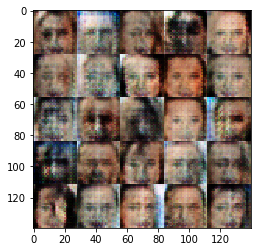

Epoch 1/1... Batch 1710... Discriminator Loss: 1.2970... Generator Loss: 0.8531
Epoch 1/1... Batch 1720... Discriminator Loss: 1.4260... Generator Loss: 0.6196
Epoch 1/1... Batch 1730... Discriminator Loss: 1.3390... Generator Loss: 0.8296
Epoch 1/1... Batch 1740... Discriminator Loss: 1.4324... Generator Loss: 1.1400
Epoch 1/1... Batch 1750... Discriminator Loss: 1.3155... Generator Loss: 0.8803
Epoch 1/1... Batch 1760... Discriminator Loss: 1.3708... Generator Loss: 0.5998
Epoch 1/1... Batch 1770... Discriminator Loss: 1.3417... Generator Loss: 0.6589
Epoch 1/1... Batch 1780... Discriminator Loss: 1.4086... Generator Loss: 0.9134
Epoch 1/1... Batch 1790... Discriminator Loss: 1.3119... Generator Loss: 0.8359
Epoch 1/1... Batch 1800... Discriminator Loss: 1.3822... Generator Loss: 0.6759


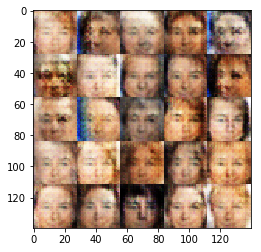

Epoch 1/1... Batch 1810... Discriminator Loss: 1.3484... Generator Loss: 0.7308
Epoch 1/1... Batch 1820... Discriminator Loss: 1.3189... Generator Loss: 0.8475
Epoch 1/1... Batch 1830... Discriminator Loss: 1.3202... Generator Loss: 0.8309
Epoch 1/1... Batch 1840... Discriminator Loss: 1.4051... Generator Loss: 0.7786
Epoch 1/1... Batch 1850... Discriminator Loss: 1.3857... Generator Loss: 0.8478
Epoch 1/1... Batch 1860... Discriminator Loss: 1.3332... Generator Loss: 0.8539
Epoch 1/1... Batch 1870... Discriminator Loss: 1.5717... Generator Loss: 0.4467
Epoch 1/1... Batch 1880... Discriminator Loss: 1.3409... Generator Loss: 0.7595
Epoch 1/1... Batch 1890... Discriminator Loss: 1.3992... Generator Loss: 0.9930
Epoch 1/1... Batch 1900... Discriminator Loss: 1.7658... Generator Loss: 0.3291


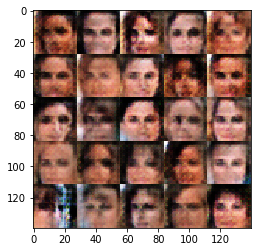

Epoch 1/1... Batch 1910... Discriminator Loss: 1.2844... Generator Loss: 0.9598
Epoch 1/1... Batch 1920... Discriminator Loss: 1.4201... Generator Loss: 0.8218
Epoch 1/1... Batch 1930... Discriminator Loss: 1.3565... Generator Loss: 0.7793
Epoch 1/1... Batch 1940... Discriminator Loss: 1.4348... Generator Loss: 0.9361
Epoch 1/1... Batch 1950... Discriminator Loss: 1.4223... Generator Loss: 0.8427
Epoch 1/1... Batch 1960... Discriminator Loss: 1.3187... Generator Loss: 0.8406
Epoch 1/1... Batch 1970... Discriminator Loss: 1.3573... Generator Loss: 0.7289
Epoch 1/1... Batch 1980... Discriminator Loss: 1.2939... Generator Loss: 0.8448
Epoch 1/1... Batch 1990... Discriminator Loss: 1.4288... Generator Loss: 0.5697
Epoch 1/1... Batch 2000... Discriminator Loss: 1.4177... Generator Loss: 0.6026


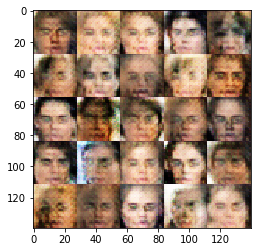

Epoch 1/1... Batch 2010... Discriminator Loss: 1.3510... Generator Loss: 1.0323
Epoch 1/1... Batch 2020... Discriminator Loss: 1.2886... Generator Loss: 0.9314
Epoch 1/1... Batch 2030... Discriminator Loss: 1.4106... Generator Loss: 0.8697
Epoch 1/1... Batch 2040... Discriminator Loss: 1.3572... Generator Loss: 0.8916
Epoch 1/1... Batch 2050... Discriminator Loss: 1.3668... Generator Loss: 0.8186
Epoch 1/1... Batch 2060... Discriminator Loss: 1.3402... Generator Loss: 0.7731
Epoch 1/1... Batch 2070... Discriminator Loss: 1.1985... Generator Loss: 0.8407
Epoch 1/1... Batch 2080... Discriminator Loss: 1.3473... Generator Loss: 1.0088
Epoch 1/1... Batch 2090... Discriminator Loss: 1.4731... Generator Loss: 0.5418
Epoch 1/1... Batch 2100... Discriminator Loss: 1.2935... Generator Loss: 1.0561


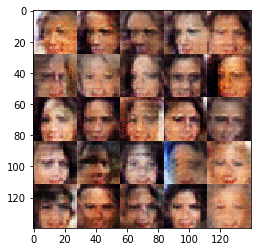

Epoch 1/1... Batch 2110... Discriminator Loss: 1.3154... Generator Loss: 0.8453
Epoch 1/1... Batch 2120... Discriminator Loss: 1.3881... Generator Loss: 0.8252
Epoch 1/1... Batch 2130... Discriminator Loss: 1.4376... Generator Loss: 0.9450
Epoch 1/1... Batch 2140... Discriminator Loss: 1.2067... Generator Loss: 0.7736
Epoch 1/1... Batch 2150... Discriminator Loss: 1.4619... Generator Loss: 0.5921
Epoch 1/1... Batch 2160... Discriminator Loss: 1.3427... Generator Loss: 0.7884
Epoch 1/1... Batch 2170... Discriminator Loss: 1.3282... Generator Loss: 0.7097
Epoch 1/1... Batch 2180... Discriminator Loss: 1.5258... Generator Loss: 0.7227
Epoch 1/1... Batch 2190... Discriminator Loss: 1.4036... Generator Loss: 0.7914
Epoch 1/1... Batch 2200... Discriminator Loss: 1.3691... Generator Loss: 0.8535


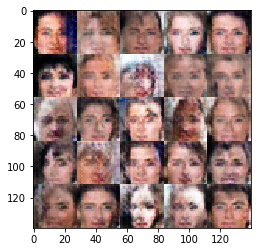

Epoch 1/1... Batch 2210... Discriminator Loss: 1.3727... Generator Loss: 0.7375
Epoch 1/1... Batch 2220... Discriminator Loss: 1.3676... Generator Loss: 1.0109
Epoch 1/1... Batch 2230... Discriminator Loss: 1.9972... Generator Loss: 0.3687
Epoch 1/1... Batch 2240... Discriminator Loss: 1.3664... Generator Loss: 0.7174
Epoch 1/1... Batch 2250... Discriminator Loss: 1.2932... Generator Loss: 0.7777
Epoch 1/1... Batch 2260... Discriminator Loss: 1.3259... Generator Loss: 0.7300
Epoch 1/1... Batch 2270... Discriminator Loss: 1.2868... Generator Loss: 0.6314
Epoch 1/1... Batch 2280... Discriminator Loss: 1.2882... Generator Loss: 0.7325
Epoch 1/1... Batch 2290... Discriminator Loss: 1.2830... Generator Loss: 0.8285
Epoch 1/1... Batch 2300... Discriminator Loss: 1.4021... Generator Loss: 0.7992


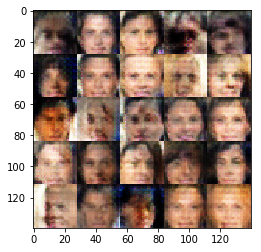

Epoch 1/1... Batch 2310... Discriminator Loss: 1.5252... Generator Loss: 0.5548
Epoch 1/1... Batch 2320... Discriminator Loss: 1.3348... Generator Loss: 0.8504
Epoch 1/1... Batch 2330... Discriminator Loss: 1.4083... Generator Loss: 0.8851
Epoch 1/1... Batch 2340... Discriminator Loss: 1.4180... Generator Loss: 0.7583
Epoch 1/1... Batch 2350... Discriminator Loss: 1.3567... Generator Loss: 0.5812
Epoch 1/1... Batch 2360... Discriminator Loss: 1.4135... Generator Loss: 0.7264
Epoch 1/1... Batch 2370... Discriminator Loss: 1.4519... Generator Loss: 0.5777
Epoch 1/1... Batch 2380... Discriminator Loss: 1.4106... Generator Loss: 0.8436
Epoch 1/1... Batch 2390... Discriminator Loss: 1.5150... Generator Loss: 0.4688
Epoch 1/1... Batch 2400... Discriminator Loss: 1.3558... Generator Loss: 0.8606


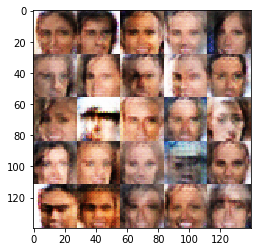

Epoch 1/1... Batch 2410... Discriminator Loss: 1.3663... Generator Loss: 0.8926
Epoch 1/1... Batch 2420... Discriminator Loss: 1.1131... Generator Loss: 0.8280
Epoch 1/1... Batch 2430... Discriminator Loss: 1.1362... Generator Loss: 0.7336
Epoch 1/1... Batch 2440... Discriminator Loss: 1.7630... Generator Loss: 0.3848
Epoch 1/1... Batch 2450... Discriminator Loss: 1.1719... Generator Loss: 0.7502
Epoch 1/1... Batch 2460... Discriminator Loss: 1.0725... Generator Loss: 1.0597
Epoch 1/1... Batch 2470... Discriminator Loss: 1.4275... Generator Loss: 0.5323
Epoch 1/1... Batch 2480... Discriminator Loss: 1.0303... Generator Loss: 1.2327
Epoch 1/1... Batch 2490... Discriminator Loss: 1.3755... Generator Loss: 1.0544
Epoch 1/1... Batch 2500... Discriminator Loss: 1.3322... Generator Loss: 0.6184


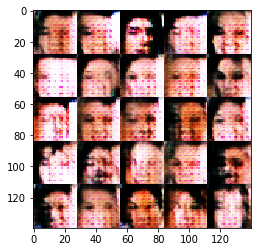

Epoch 1/1... Batch 2510... Discriminator Loss: 1.1081... Generator Loss: 1.0628
Epoch 1/1... Batch 2520... Discriminator Loss: 1.2163... Generator Loss: 0.8305
Epoch 1/1... Batch 2530... Discriminator Loss: 0.8977... Generator Loss: 0.9726
Epoch 1/1... Batch 2540... Discriminator Loss: 1.6747... Generator Loss: 1.2648
Epoch 1/1... Batch 2550... Discriminator Loss: 1.3145... Generator Loss: 0.7410
Epoch 1/1... Batch 2560... Discriminator Loss: 1.9858... Generator Loss: 0.2924
Epoch 1/1... Batch 2570... Discriminator Loss: 1.3190... Generator Loss: 0.7027
Epoch 1/1... Batch 2580... Discriminator Loss: 1.4071... Generator Loss: 0.7224
Epoch 1/1... Batch 2590... Discriminator Loss: 1.6955... Generator Loss: 0.5481
Epoch 1/1... Batch 2600... Discriminator Loss: 1.3148... Generator Loss: 1.0030


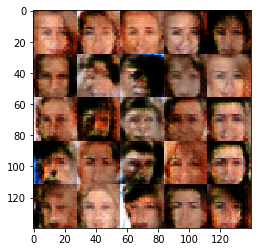

Epoch 1/1... Batch 2610... Discriminator Loss: 1.4086... Generator Loss: 0.5984
Epoch 1/1... Batch 2620... Discriminator Loss: 1.4125... Generator Loss: 0.5600
Epoch 1/1... Batch 2630... Discriminator Loss: 1.3101... Generator Loss: 0.5913
Epoch 1/1... Batch 2640... Discriminator Loss: 1.2307... Generator Loss: 0.9553
Epoch 1/1... Batch 2650... Discriminator Loss: 1.2492... Generator Loss: 0.7738
Epoch 1/1... Batch 2660... Discriminator Loss: 1.4202... Generator Loss: 0.9237
Epoch 1/1... Batch 2670... Discriminator Loss: 1.2812... Generator Loss: 0.8935
Epoch 1/1... Batch 2680... Discriminator Loss: 1.2721... Generator Loss: 0.6327
Epoch 1/1... Batch 2690... Discriminator Loss: 1.4162... Generator Loss: 0.7613
Epoch 1/1... Batch 2700... Discriminator Loss: 1.3168... Generator Loss: 0.8336


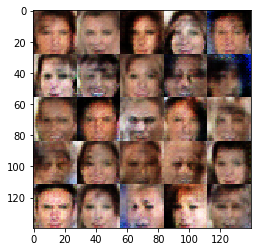

Epoch 1/1... Batch 2710... Discriminator Loss: 1.2522... Generator Loss: 1.1327
Epoch 1/1... Batch 2720... Discriminator Loss: 1.3897... Generator Loss: 0.5886
Epoch 1/1... Batch 2730... Discriminator Loss: 1.3738... Generator Loss: 0.8744
Epoch 1/1... Batch 2740... Discriminator Loss: 1.3458... Generator Loss: 0.7711
Epoch 1/1... Batch 2750... Discriminator Loss: 1.5664... Generator Loss: 0.5358
Epoch 1/1... Batch 2760... Discriminator Loss: 1.5499... Generator Loss: 0.5025
Epoch 1/1... Batch 2770... Discriminator Loss: 1.4077... Generator Loss: 0.7744
Epoch 1/1... Batch 2780... Discriminator Loss: 1.2448... Generator Loss: 0.8366
Epoch 1/1... Batch 2790... Discriminator Loss: 1.3728... Generator Loss: 0.8892
Epoch 1/1... Batch 2800... Discriminator Loss: 1.3788... Generator Loss: 0.6568


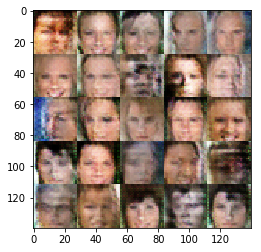

Epoch 1/1... Batch 2810... Discriminator Loss: 1.1369... Generator Loss: 0.9323
Epoch 1/1... Batch 2820... Discriminator Loss: 1.3602... Generator Loss: 0.6250
Epoch 1/1... Batch 2830... Discriminator Loss: 1.3031... Generator Loss: 0.7544
Epoch 1/1... Batch 2840... Discriminator Loss: 1.2061... Generator Loss: 0.7962
Epoch 1/1... Batch 2850... Discriminator Loss: 1.2874... Generator Loss: 0.7989
Epoch 1/1... Batch 2860... Discriminator Loss: 1.2724... Generator Loss: 0.8711
Epoch 1/1... Batch 2870... Discriminator Loss: 1.6496... Generator Loss: 0.4065
Epoch 1/1... Batch 2880... Discriminator Loss: 1.2862... Generator Loss: 0.8521
Epoch 1/1... Batch 2890... Discriminator Loss: 1.3271... Generator Loss: 0.8235
Epoch 1/1... Batch 2900... Discriminator Loss: 1.2393... Generator Loss: 0.7608


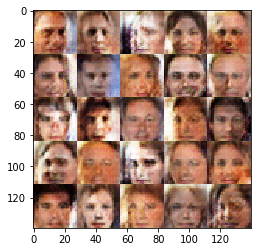

Epoch 1/1... Batch 2910... Discriminator Loss: 1.3828... Generator Loss: 1.1647
Epoch 1/1... Batch 2920... Discriminator Loss: 1.2940... Generator Loss: 0.7692
Epoch 1/1... Batch 2930... Discriminator Loss: 1.4686... Generator Loss: 0.6228
Epoch 1/1... Batch 2940... Discriminator Loss: 1.3336... Generator Loss: 0.8072
Epoch 1/1... Batch 2950... Discriminator Loss: 1.1522... Generator Loss: 0.8194
Epoch 1/1... Batch 2960... Discriminator Loss: 1.3803... Generator Loss: 0.9487
Epoch 1/1... Batch 2970... Discriminator Loss: 1.6391... Generator Loss: 0.4775
Epoch 1/1... Batch 2980... Discriminator Loss: 1.1705... Generator Loss: 0.7426
Epoch 1/1... Batch 2990... Discriminator Loss: 1.4234... Generator Loss: 0.6358
Epoch 1/1... Batch 3000... Discriminator Loss: 1.3319... Generator Loss: 0.7006


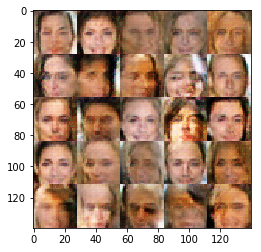

Epoch 1/1... Batch 3010... Discriminator Loss: 1.3330... Generator Loss: 0.8118
Epoch 1/1... Batch 3020... Discriminator Loss: 1.7785... Generator Loss: 0.4290
Epoch 1/1... Batch 3030... Discriminator Loss: 1.3663... Generator Loss: 0.8034
Epoch 1/1... Batch 3040... Discriminator Loss: 1.4570... Generator Loss: 0.7210
Epoch 1/1... Batch 3050... Discriminator Loss: 1.2920... Generator Loss: 0.7280
Epoch 1/1... Batch 3060... Discriminator Loss: 1.5454... Generator Loss: 0.8072
Epoch 1/1... Batch 3070... Discriminator Loss: 1.3693... Generator Loss: 0.8269
Epoch 1/1... Batch 3080... Discriminator Loss: 1.3736... Generator Loss: 0.6712
Epoch 1/1... Batch 3090... Discriminator Loss: 1.6588... Generator Loss: 0.5509
Epoch 1/1... Batch 3100... Discriminator Loss: 1.3912... Generator Loss: 0.6776


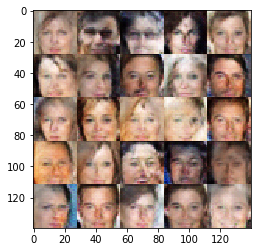

Epoch 1/1... Batch 3110... Discriminator Loss: 1.3549... Generator Loss: 0.7972
Epoch 1/1... Batch 3120... Discriminator Loss: 1.4256... Generator Loss: 0.5905
Epoch 1/1... Batch 3130... Discriminator Loss: 1.7597... Generator Loss: 0.4070
Epoch 1/1... Batch 3140... Discriminator Loss: 1.4184... Generator Loss: 0.8600
Epoch 1/1... Batch 3150... Discriminator Loss: 1.3779... Generator Loss: 0.9036
Epoch 1/1... Batch 3160... Discriminator Loss: 1.3463... Generator Loss: 0.6078


In [24]:
batch_size = 64
z_dim = 95
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

In [24]:
print("done")

done
